In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('whitegrid')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def hamiltonian(qp):
    q = qp[0]
    p = qp[1]
    return 0.5 * p**2 + 0.5 * q**2

In [4]:
def dhdq_func(qp):
    q = qp[0]
    return q

def dhdp_func(qp):
    p = qp[1]
    return p

In [5]:
def symplectic(t, qp):
    dhdq = dhdq_func(qp)
    dhdp = dhdp_func(qp)
    return [dhdp, -dhdq]    

In [6]:
def mass_spring(energies, t_span, t_points):
    q = []
    p = []

    q_dot = []
    p_dot = []

    t_eval = np.sort(np.linspace(t_span[0], t_span[1], t_points))

    for E in energies:
        t = np.random.uniform(0, 2)
        q_init = np.sqrt(2 * E) * np.cos(t)
        p_init = np.sqrt(2 * E) * np.sin(t)
        y0 = [q_init, p_init]
        
        symplectic_ivp = solve_ivp(fun=symplectic, t_span=t_span, y0=y0, t_eval=np.sort(t_eval))
        q.append(symplectic_ivp['y'][0] + np.random.normal(0, 0.1, t_points))
        p.append(symplectic_ivp['y'][1] + np.random.normal(0, 0.1, t_points))
        
        dots = np.array([np.array(symplectic(None, qp)) for qp in symplectic_ivp['y'].T])
        q_dot.append(dots[:,0])
        p_dot.append(dots[:,1])
            
    q = np.array(q)
    p = np.array(p)

    q_dot = np.array(q_dot)
    p_dot = np.array(p_dot)

    return q, p, q_dot, p_dot


In [7]:
def diff_hnn(model, qp):
    qp = torch.autograd.Variable(qp, requires_grad=True).to(device)
    out = torch.autograd.grad(model(qp).sum(), qp, create_graph=True)[0].to(device)

    return model(qp).sum(), out @ torch.Tensor([[0, -1],[1, 0]]).to(device)

In [8]:
# energies
energies = np.random.uniform(0.2, 1, 50)

In [9]:
q, p, q_dot, p_dot = mass_spring(energies, [0, 100], 200)

Text(0.5, 1.0, 'Generated phase space trajectory with added noise')

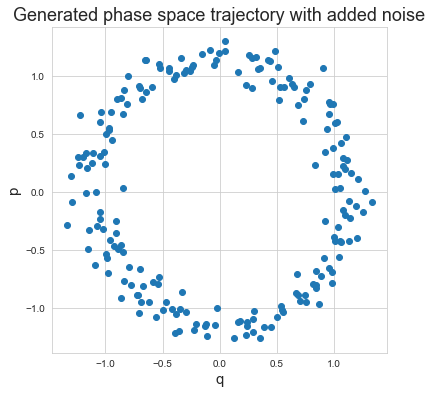

In [10]:
plt.figure(figsize=(6,6))

plt.scatter(q[0], p[0])
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.title('Generated phase space trajectory with added noise', size=18)

In [11]:
X = np.stack((q, p), axis=-1)
y = np.stack((q_dot, p_dot), axis=-1)

In [12]:
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).to(device)
X.shape

torch.Size([50, 200, 2])

In [13]:
train_X, test_X = np.split(X, 2, axis=0)
train_y, test_y = np.split(y, 2, axis=0)

# Models

In [14]:
# models
from models import MLP, HNN

baseline = MLP(dims=1).to(device)
hnn_model = HNN(dims=1).to(device)

In [15]:
trainset = torch.utils.data.TensorDataset(train_X, train_y)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=25, shuffle=True, num_workers=0)

In [16]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer1 = optim.Adam(baseline.parameters(), lr=1e-3)
optimizer2 = optim.Adam(hnn_model.parameters(), lr=1e-3)

In [17]:
%%time
# baseline training
for epoch in range(150):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = baseline(inputs)
        loss = criterion(outputs[0], labels[0]) + criterion(outputs[1], labels[1])

        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        if (epoch + 1) % 20 == 0:
            print('Epoch: %d | MSE Loss: %.5f' % (epoch + 1, running_loss))
            running_loss = 0.0
            
print('-----------------------------')
print('Finished Training')

Epoch: 20 | MSE Loss: 0.08021
Epoch: 40 | MSE Loss: 0.01962
Epoch: 60 | MSE Loss: 0.02324
Epoch: 80 | MSE Loss: 0.02088
Epoch: 100 | MSE Loss: 0.01808
Epoch: 120 | MSE Loss: 0.01896
Epoch: 140 | MSE Loss: 0.02352
-----------------------------
Finished Training
Wall time: 1.1 s


In [18]:
%%time
# HNN training
for epoch in range(150):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = diff_hnn(hnn_model, inputs)[1]
        loss = criterion(outputs[0], labels[0]) + criterion(outputs[1], labels[1])

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if (epoch + 1) % 20 == 0:
            print('Epoch: %d | MSE Loss: %.5f' % (epoch + 1, running_loss))
            running_loss = 0.0
            
print('-----------------------------')
print('Finished Training')

Epoch: 20 | MSE Loss: 0.02839
Epoch: 40 | MSE Loss: 0.02903
Epoch: 60 | MSE Loss: 0.02791
Epoch: 80 | MSE Loss: 0.01928
Epoch: 100 | MSE Loss: 0.02672
Epoch: 120 | MSE Loss: 0.01837
Epoch: 140 | MSE Loss: 0.01681
-----------------------------
Finished Training
Wall time: 738 ms


In [19]:
def hnn_func(t, qp):
    qp = torch.Tensor(qp).to(device)
    qp = torch.autograd.Variable(qp, requires_grad=True)
    out = diff_hnn(hnn_model, qp)[1]
    return out.to("cpu").clone().detach().numpy()

In [20]:
def baseline_func(t, qp):
    qp = torch.Tensor(qp).to(device)
    qp = torch.autograd.Variable(qp, requires_grad=True)
    out = baseline(qp)
    return out.to("cpu").clone().detach().numpy()

In [21]:
test_X = test_y.to("cpu").clone().detach().numpy()
test_y = test_y.to("cpu").clone().detach().numpy()

In [22]:
t_eval = np.sort(np.linspace(0, 100, 200))
trajectory_num = 2

pred_hnn = solve_ivp(fun=hnn_func, t_span=[0, 100], y0=test_X[trajectory_num][0], t_eval=np.sort(t_eval))
pred_baseline = solve_ivp(fun=baseline_func, t_span=[0, 100], y0=test_X[trajectory_num][0], t_eval=np.sort(t_eval))

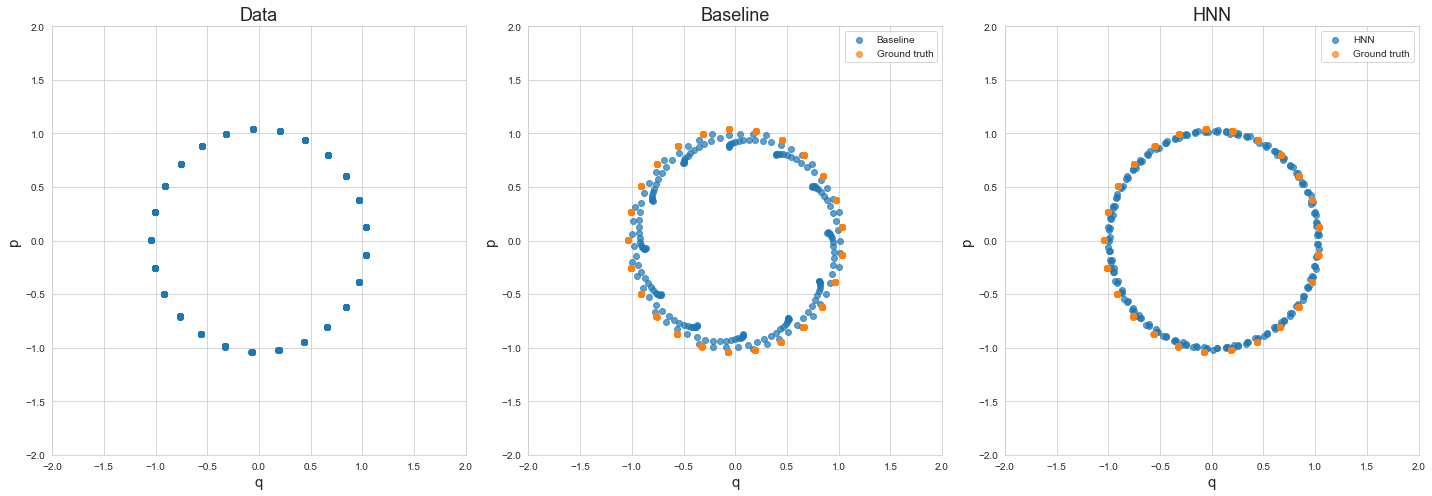

In [23]:
plt.figure(figsize=(20,7))

plt.subplot(131)
plt.scatter(test_y[trajectory_num][:,0], test_y[trajectory_num][:,1])
plt.title('Data', size=18)
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

plt.subplot(132)
plt.scatter(pred_baseline['y'][0], pred_baseline['y'][1], alpha=0.7, label='Baseline')
plt.scatter(test_y[trajectory_num][:,0], test_y[trajectory_num][:,1], alpha=0.7, label='Ground truth')
plt.title('Baseline', size=18)
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend(loc='upper right')

plt.subplot(133)
plt.scatter(pred_hnn['y'][0], pred_hnn['y'][1], alpha=0.7, label='HNN')
plt.scatter(test_y[trajectory_num][:,0], test_y[trajectory_num][:,1], alpha=0.7, label='Ground truth')
plt.title('HNN', size=18)
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend(loc='upper right')

plt.tight_layout()

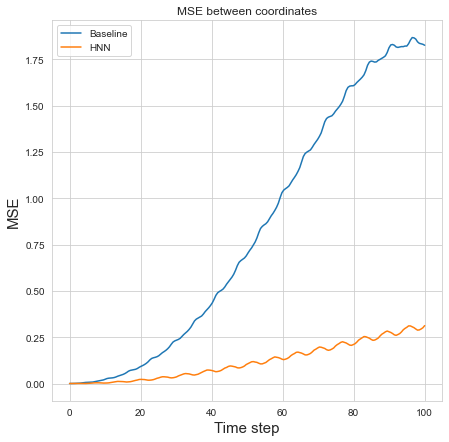

In [24]:
plt.figure(figsize=(7,7))

plt.plot(np.sort(t_eval), ((test_y[trajectory_num]-pred_baseline['y'].T)**2).mean(1), label='Baseline')
plt.plot(np.sort(t_eval), ((test_y[trajectory_num]-pred_hnn['y'].T)**2).mean(1), label='HNN')
plt.xlabel('Time step', size=15)
plt.ylabel('MSE', size=15)
plt.title('MSE between coordinates')
plt.legend()

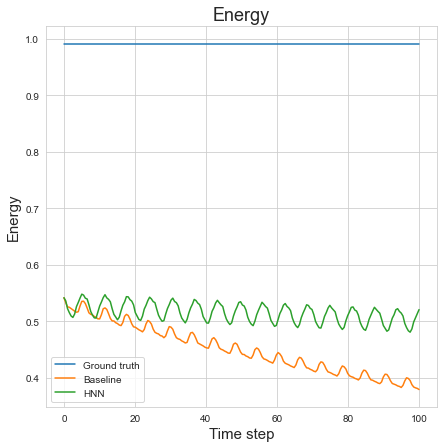

In [25]:
plt.figure(figsize=(7,7))

plt.plot(np.sort(t_eval), [energies[trajectory_num] for i in t_eval], label='Ground truth')
plt.plot(np.sort(t_eval), [hamiltonian(pred_baseline['y'].T[i]) for i in range(200)], label='Baseline')
plt.plot(np.sort(t_eval),  [hamiltonian(pred_hnn['y'].T[i]) for i in range(200)], label='HNN')
plt.xlabel('Time step', size=15)
plt.ylabel('Energy', size=15)
plt.title('Energy', size=18)
plt.legend()